# Lab 5: Deep Learning Internals

## This is a special lab

In the last lab, we introduced the Perceptron with weights, biases and activation functions and fully connected Neural Networks. This lab is a bit different from all the other labs, and it is for the reader who is interested in understanding the inner workings of a Neural Network.

In this lab, we learn about gradient descent and backpropagation, which is more technical and abstract than the rest of the labs. We will use mathematical formulas and weird symbols, talk about derivatives and gradients. We will try to make these concepts as intuitive and comfortable as possible, but these are complex topics, and it is not possible to introduce them fully without going into some level of detail.

Let us first tell you: **you don't NEED to read this lab**. This labs is for the developer and practitioner that is interested in applying Neural Networks to solve real-world problems. As such, all the previous and following labs are focused on the implementation of Neural Networks and their practical application. This lab is different from all the others, you will not learn new techniques here, you will not learn new commands or tricks, nor we will introduce any new Neural Network architecture.

All this lab does, is to explain what happens when you run the function `model.fit`, i.e., break down how a Neural Network learns. As we have already seen in labs 3 and 4 after we define the model architecture we usually do two more steps:

1. we `.compile` the model specifying the optimizer and the cost function
- we `.fit` the model for a certain number of epochs using the training data

Keras executes these two operations for us, and we don't have to worry about them too much. However, I'm sure you've been wondering why we choose a particular optimizer at compilation or what is happening during training.

This lab explains precisely that.

In our opinion, it is essential to learn this for a few reasons. First of all, understanding these concepts allow us to demystify what's happening under the hood in our network. Neural Networks are not magic, and knowing these concepts can give us a better ability to judge where we can use them to solve problems and where we cannot. Secondly, knowing the internal mechanisms increases our abilities to understand which knobs to tweak and which optimization algorithms to choose.

So, let us re-iterate this once again: feel free to skip this lab if your primary goal is to learn how to use Keras and to apply Neural Networks. You won't find new code here, mostly a lot of maths and formulas.

On the other hand, if your goal is to understand how things work, then go ahead and read it. Chances are you will find the answers to some of your questions in this lab.

Finally, if you are already familiar with derivatives and college calculus, you can probably skim through large portions of this lab quite quickly.

All that said, let's start by introducing derivatives and gradients. First let's import our usual libraries. By now you should be very familiar with all of them, but if in doubt on what they do, check back [Lab 2](./02_Data_Manipulation.ipynb) where we introduced them:

In [1]:
with open('common.py') as fin:
    exec(fin.read())

In [2]:
with open('matplotlibconf.py') as fin:
    exec(fin.read())

## Derivatives

As the name suggests a **derivative** is a function that derives from another function.

Let's start with an example. Imagine you are driving on the highway. As time goes by you mark your position along the road, filling a table of values as a function of time. If your speed is 60 miles an hour, every minute your position will increase by 1 mile.

Let's indicate your position as a function of time with the variable $x(t)$. Let's create an array of 10 minutes, called `t` and an array of your positions called `x`:

In [3]:
t = np.arange(10)
x = np.arange(10)

Now, let's make a plot to see the distance over time with respect to the distance traveled.

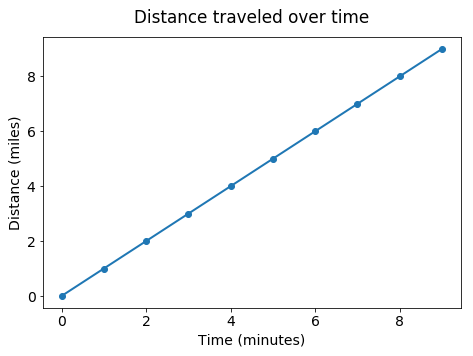

In [4]:
plt.plot(t, x, 'o-')
plt.title("Distance traveled over time")
plt.ylabel("Distance (miles)")
plt.xlabel("Time (minutes)");

The derivative $x'(t)$ of this function is the **rate of change** in position with respect to time. In this example it is the speed of your car indicated by the odometer. In the example just mentioned, the derivative is a constant value of 60 miles per hour, or 1 mile per minute. Let's create an array containing the speed at each moment in time:

In [5]:
v = np.ones(10) # 1 mile per minute or 60 miles per hour

and let's plot it too:

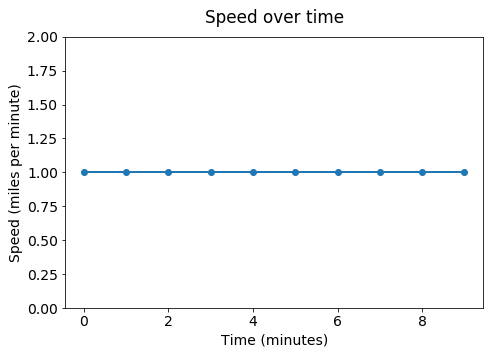

In [6]:
plt.plot(t, v, 'o-')
plt.ylim(0, 2)
plt.title("Speed over time")
plt.ylabel("Speed (miles per minute)")
plt.xlabel("Time (minutes)");

In general, the derivative $x'(t)$ is itself a function of $t$ that tells us the rate of change of the original function $x(t)$ at each point in time. This is why it is called a **derivative**. It can also be written explicitly as:

\begin{equation}
x'(t) := \frac{dx}{dt}(t)
\end{equation}

Where the fraction $\frac{dx}{dt}$ indicates the ratio between a small change in $x$ due to a small change in $t$. Let's look at a case where the derivative is not constant. Consider an arbitrary curve $f(t)$. Let's first create a slightly bigger time array:

In [7]:
t = np.linspace(0, 2*np.pi,360)

Then let's take an arbitrary function and let's apply it to the array $t$. We will use the sine function, but that's just an example, any function would do:

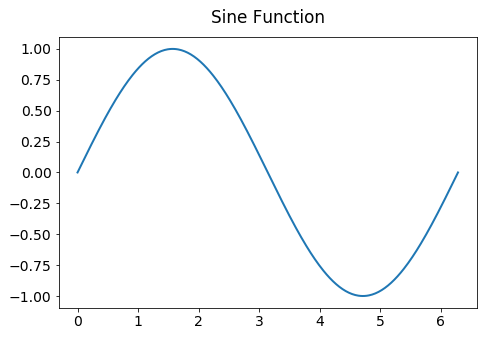

In [8]:
f = np.sin(t)
plt.plot(t, f)
plt.title("Sine Function");

At each point along the curve $f(t)$, the derivative $f'(t)$ is equal to the rate of change in the function.

### Finite differences

How do we calculate the value of the derivative at a particular point in $t$? We can calculate its approximate value with the method of [finite differences](https://en.wikipedia.org/wiki/Finite_difference):

\begin{equation}
\frac{df}{dt}(t_i) \approx \frac{\Delta f}{\Delta t}(t_i)  = \frac{f(t_{i}) - f(t_{i-1})}{t_{i} - t_{i-1}}
\end{equation}

where we indicated with $\Delta f$ the difference between two consecutive values of $f$.

We can calculate the value of the approximate derivative of the above function by using the function `np.diff` that calculates the difference between consecutive elements in an array:

In [9]:
dfdt = np.diff(f)/np.diff(t)

Let's plot it together with the original function:

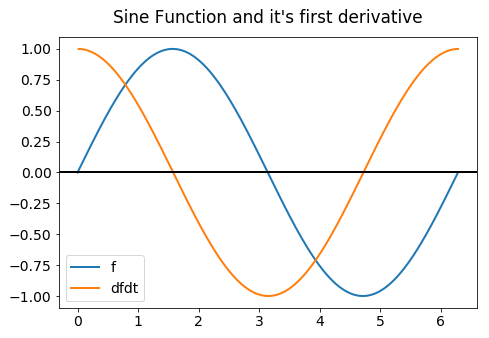

In [10]:
plt.plot(t, f)
plt.plot(t[1:], dfdt)
plt.legend(['f', 'dfdt'])
plt.axhline(0, color='black')
plt.title("Sine Function and it's first derivative");

If we read the figure from left to right, we notice that the value of the derivative is negative when the original curve is going downhill, and it is positive when the original curve is going uphill. Finally, if we're at a minimum or a maximum, the derivative is 0 because the original curve is flat.

Let's define a simple helper function to plot the [tangent line](https://en.wikipedia.org/wiki/Tangent) to our curve, i.e., the line that "just touches" the curve at that point:

In [11]:
def plot_tangent(i, color='r'):
    
    plt.plot(t, f)
    plt.plot(t[:-1], dfdt)
    plt.legend(['f', '$\\frac{df}{dt}$'])
    plt.axhline(0)
    
    ti = t[i]
    fi = f[i]
    dfdti = dfdt[i]

    plt.plot(ti, fi, 'o', color=color)
    plt.plot(ti, dfdti, 'o', color=color)

    x = np.linspace(-0.75, 0.75, 20)
    n = 1 + dfdti**2

    plt.plot(ti + x/n, fi + dfdti*x/n, color,
             linewidth=3)

We can use this helper function to display the relationship between the inclination (slope) of our tangent line and the value of the derivative function. As you can see, a positive derivative corresponds to an uphill tangent while negative derivative corresponds to a downhill tangent line.

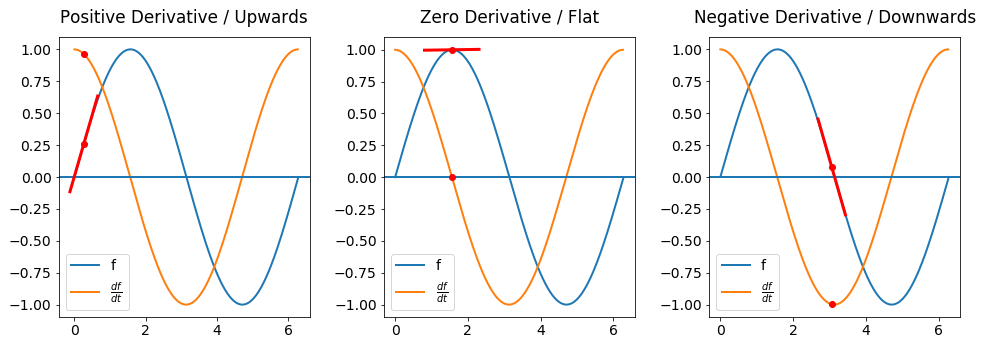

In [12]:
plt.figure(figsize=(14,5))

plt.subplot(131)
plot_tangent(15)
plt.title("Positive Derivative / Upwards")
plt.subplot(132)
plot_tangent(89)
plt.title("Zero Derivative / Flat")
plt.subplot(133)
plot_tangent(175)
plt.title("Negative Derivative / Downwards")
plt.tight_layout();

Although the finite differences method is useful to calculate the numerical value of a derivative, we don't need to use it. Derivatives of simple functions are well known, and we don't need to calculate them. [Calculus](https://en.wikipedia.org/wiki/Calculus) is the branch of mathematics that deals with all this. For our purposes we will summarize here a few common functions and their derivatives:


![Common functions and their derivatives](./assets/derivatives.png)

### Partial derivatives and the gradient

When our function has more than one input variable, we need to specify which variable we are using for derivation. For example, let's say we measure our elevation on a mountain as a function of our position. Our GPS position is defined by two variables: longitude and latitude, and therefore the elevation depends on two variables: $y = f(x_1, x_2)$.

We can calculate the **rate of change in elevation with respect to $x_1$, and the rate of change with respect $x_2$** independently. These are called **partial derivatives**, because we only consider the change with respect to one variable. We will indicate them with a "curly d" symbol:

$$
\frac{\partial f}{\partial x_1} \text{, } \frac{\partial f}{\partial x_2}
$$

If we are on top of a hill, the fastest route downhill will not necessarily be along any of the north-south or east-west directions. It will be in whatever direction it is more steeply descending.

In the two dimensional plane of $x_1$ and $x_2$, the direction of the most abrupt change will be a 2-dimensional vector whose components are the partial derivatives with respect to each variable. We call this vector the **Gradient**, and we indicate it with an inverted triangle called _del_ or _nabla_: $\nabla$.

The gradient is an operation that takes a function of multiple variables and returns a vector. The components of this vector are all the partial derivatives of the function. Since the partial derivatives are functions of all variables, the gradient is also a function of all variables. To be precise, it is a vector function.

For each point, $(x_1, x_2)$, the gradient returns the **vector in the direction of maximum steepness** in the graph of the original function. If we want to go downhill, all we have to do is walk in the direction opposite to the gradient. This will be our strategy for minimizing cost functions.

So we have an operation, the gradient, which takes a function of multiple variables and returns a vector in the direction of maximum steepness. Pretty cool!

![Visualization of gradient in a landscape](./assets/gradient_mountain.png)

Why is this neat? Why is it important? Well, it turns out that we can use this idea to train our networks.

## Backpropagation intuition

Now that we have defined the gradient, let's talk about backpropagation.

Backpropagation is a core concept in Machine Learning. The next several sections work through the math of backpropagation. As said at the beginning of this lab, it is not necessary to understand the maths to be able to build and apply a Deep Learning model. However, the math is not very hard, and with a little bit of exercise, you'll be able to see that there is no mystery behind how Neural Networks function.

At a high-level, the backpropagation algorithm is a Supervised Learning method for training our networks. It uses the error between the model prediction and the ground truth labels to modify the model weights to reduce the error in the next iteration.

The starting point for backpropagation is the [Cost Function](https://en.wikipedia.org/wiki/Loss_function) we have introduced in [Lab 3](./03_Machine_Learning.ipynb#Cost-function).

Let's consider a generic cost function of a network with just one weight, let's call this function $J(w)$. For every value of the weight $w$, the function calculates a value of the cost $J(w)$.

![Linear regression and its loss](./assets/regression_cost.png)

The figure shows this situation for the case of a Linear Regression. As seen in [Lab 3](./03_Machine_Learning.ipynb#Finding-the-best-model), different lines correspond to different values of $w$. In the figure, we represented them with different colors. Each line produces a different cost, here represented with a dot of different color and our goal is to find the value of $w$ that corresponds to the minimum of $J(w)$.

A bit of algebra solves linear regression easily, but how do we deal with the general case of a network with millions of weights and biases? The cost function $J$ now depends on millions of parameters, and it is not obvious how to search for a minimum value.

What is clear is that the shape of such a cost function is not going to be a smooth parabola like the one in the figure, and we will need a way to navigate a very complex landscape in search for a minimum value.

Let's say we are sitting at a particular point $w_0$, corresponding to cost $J(w_0)$, how do we move towards lower costs?

We want to move in the direction of decreasing $J(w)$ until we reach the minimum, but we can only use local information. How do we decide where to go?

![Weight update](./assets/cost_w0.png)

As we saw when we talked about descending from a hill, the derivative indicates its slope at each point. So, to move towards lower values, we need to calculate the derivative at $w_0$ and then change our position by subtracting the value of the derivative from the value of our starting position $w_0$.

Programmatically speaking, we can take one step in the direction where the descent algorithm is the lowest, i.e., that minimizes the cost function.

Mathematically speaking, we can take one step following the rule:

\begin{equation}
w_0 -> w_0 - \frac{dJ}{dw}(w_0)
\end{equation}

Let's check that this does move us towards lower values on the vertical axis.

If we are at $w_0$ like in the figure, the slope of the curve is negative and thus the quantity $-\frac{dJ}{dw}(w_0)$ is positive. So, the value of $w_0$ will increase, moving us towards the right on the horizontal axis.

The corresponding value on the vertical axis will decrease, and we successfully moved towards a lower value of the function $f(w)$.

Vice versa, if we were to start at a point $w_0$ where the value of the slope is positive, we would subtract a positive quantity $\frac{dJ}{dw}(w_0)$ that is now negative. This would move $w_0$ to the left, and the corresponding values on the vertical axis would still decrease.

## Learning Rate

The update rule we have just introduced one more modification. As it is, it suffers from two problems. If the cost function is very flat, the derivative will be very very small, and with the current update rule, we will move very very slowly towards the minimum. Viceversa, if the cost function is very steep, the derivative will be very large, and we might end up jumping beyond the minimum.

A simple solution to both problems is to introduce a tunable knob that allows us to decide how big of a step to take in the direction of the gradient. This is the **learning rate**, and we will indicate it with the Greek letter $\eta$:

$$
w_0 -> w_0 - \eta \frac{dJ}{dw}(w_0)
$$


If we choose a small learning rate, we will move by tiny steps. A larger learning rate will move us by more significant steps.

However, we must be careful. If the learning rate is too high, we will run away from the solution. At each new step we move towards the direction of the minimum, but since the step is too large, we overshoot and go beyond the minimum, at which point we reverse course and repeat, going further and further away.

## Gradient descent

This way of looking for the minimum of a function is called **Gradient Descent** and it is the idea behind backpropagation. Given a function, we can move towards its minimum by following the path indicated by its derivative, or in the case of multiple variables, indicated by the gradient.

For a Neural Network, we define a cost function that depends on the values of the parameters, and we find the values of the parameters by minimizing such cost through gradient descent.

The **cost function** is the method for how we can optimize our networks. It's the backbone for a lot of different Machine Learning and Deep Learning techniques.

All we are doing is taking the cost function, calculating its partial derivatives with respect to each parameter, and then using update rule to decrease the cost. We do this by subtracting the value of the negative gradient from the parameters themselves. This is a **parameter update**.

## Gradient calculation in Neural Networks

Let's recap what we've learned so far.

We know that the gradient is a function that indicates the direction of maximum steepness. We also know that we can move towards the minimum of a function by taking consecutive steps in the direction of the gradient at each point we visit.

Let's see this with a programming example. We'll use an invented cost function. Let's start by defining an array `x` with 100 points in the interval `[-4, 4]`:

In [13]:
x = np.linspace(-4, 4, 100)

Then let's define an invented cost function $J(w)$ that depends on $w$ in some weird way.

\begin{equation}
J(w) = 70.0 - 15.0 w^2 + 0.5 w^3 + w^4
\end{equation}

In [14]:
def J(w):
    return 70.0 - 15.0*w**2 + 0.5*w**3 + w**4

Using the table of derivatives [presented earlier](./05_Deep_Learning_Internals.ipynb#Partial-derivatives-and-Gradient) we can also quickly calculate its derivative.

\begin{equation}
\frac{dJ}{dw}(w) = - 30.0 w + 1.5 w^2 + 4 w^3
\end{equation}

In [15]:
def dJdw(w):
    return - 30.0*w + 1.5*w**2 + 4*w**3

Let's plot both functions:

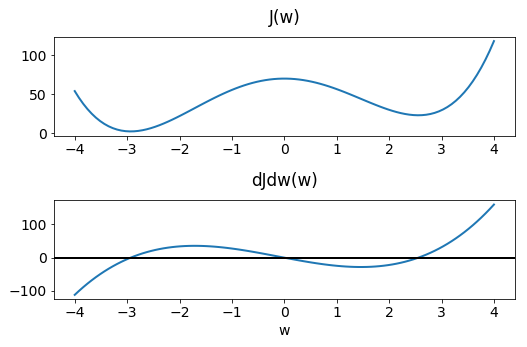

In [16]:
plt.subplot(211)
plt.plot(x, J(x))
plt.title("J(w)")

plt.subplot(212)
plt.plot(x, dJdw(x))
plt.axhline(0, color='black')
plt.title("dJdw(w)")
plt.xlabel("w")

plt.tight_layout();

Now let's find the minimum value of $J(w)$ by gradient descent. The function we have chosen has two minima, one is a local minimum, the other is the global minimum. If we apply plain gradient descent we will stop at the minimum that is nearest to where we started. Let's keep this in mind for later.

Let's start from a random initial value of $w_0 = -4$:

In [17]:
w0 = -4

and let's apply the update rule:

\begin{equation}
w_0 -> w_0 - \eta \frac{dJ}{dw}(w_0)
\end{equation}

We will choose a small learning rate of $\eta = 0.001$ initially:

In [18]:
lr = 0.001

The update step is:

In [19]:
step = lr * dJdw(w0)
step

-0.112

and the new value of $w_0$ is:

In [20]:
w0 - step

-3.888

i.e. we moved to the right, towards the minimum!

Let's do 30 iterations and se where we get:

In [21]:
iterations = 30

w = w0

ws = [w]

for i in range(iterations):
    step = lr * dJdw(w)
    w -= step
    ws.append(w)

ws = np.array(ws)

Let's visualize our descent, zooming in the interesting region of the curve:

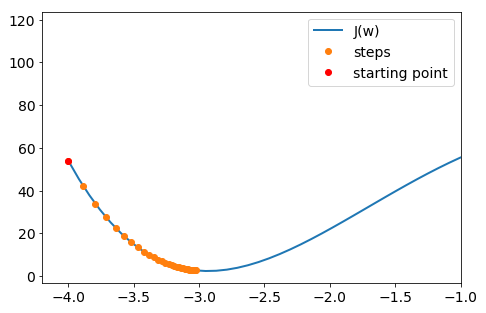

In [22]:
plt.plot(x, J(x))
plt.plot(ws, J(ws), 'o')
plt.plot(w0, J(w0), 'or')
plt.legend(["J(w)", "steps", "starting point"])
plt.xlim(-4.2, -1);

As you can see, we proceed with small steps towards the minimum, and there we stop. Try to modify the starting point and re-run the code above to fully understand how this works.

Why is this relevant to Neural Networks?

Remember that a Neural Network is just a function that connects our inputs $X$ to our outputs $y$. We'll refer to this function as $\hat{y} = f(X)$. This function depends on a set of weights $w$ that modulate the output of a layer when transferring it to the next layer, and on a set of biases $b$.

Also, remember that we defined a cost $J(\hat{y}, y) = J(f(X, w, b), y)$ that is calculated using the training set. So, for fixed training data, the cost $J$ is a function of the parameters $w$ and $b$.

The best model is the one that minimizes the cost. We can **use gradient descent on the cost function** to update the values of the parameters $w$ and $b$. The gradient will tell us in which direction to update our parameters, and it is crucial to learning the optimal values of our network parameters.

First, we calculate the gradient for each weight (and bias): $\frac{\partial J}{\partial w}$ and then we update each weight using the learning rate we have just introduced: $w_0 -> w_0 - \eta \frac{\partial J}{\partial w}$.

All we need to do at this point is to learn how to calculate the calculate the gradient $\frac{\partial J}{\partial w}$.

## The math of backpropagation

![](./assets/warning_math.png)


In this section, we will work through the calculation of the gradient for a very simple Neural Network. We are going to use equations and maths. As said previously, feel free to skim through this part if you're focused on applications, you can always come back later to go deeper in the subject. We will start with a network with only one input, one inner node and one output. This will make our calculations easier to follow.

![](./assets/simple_net.png)

In order to make the math easier to follow we will break down this graph and highlight the operations involved:

![](./assets/full_graph.png)

Starting from the left, the input is multiplied with the first weight $w^{(1)}$, then the bias $b^{(1)}$ is added and the sigmoid activation function is applied. This completes the first layer. Then we multiply the output of the first layer by the second weight $w^{(2)}$, we add the second bias $b^{(2)}$ and we apply another sigmoid activation function. This gives us the output $\hat{y}$. Finally we use the output $\hat{y}$ and the labels $y$ to calculate the cost $J$.

### Forward Pass

Let's formalize the operations described above with math. The forward pass equations are written as follows:

\begin{align}
z^{(1)} & =  x w^{(1)} + b^{(1)} \\
a^{(1)} & =  \sigma(z^{(1)}) \\
z^{(2)} & =  a^{(1)} w^{(2)} + b^{(2)} \\
\hat{y} & =  a^{(2)} = \sigma(z^{(2)}) \\
J       & = J(\hat{y}, y) \\
\end{align}

The input-sum $z^{(1)}$ is obtained through a linear transformation of the input $x$ with weight $w^{(1)}$ and bias $b^{(1)}$. In this case, we only have one input, so there really is no weighted "sum", but we still call it input-sum to remind ourselves of the general case where multiple inputs and multiple weights are present.

The activation $a^{(1)}$ is obtained by applying the sigmoid function to the input-sum $z^{(1)}$, and it is indicated by the letter  $\sigma$ (pronounced _sigma_). A similar set of equations holds for the second layer with input-sum $z^{(2)}$ and activation $a^{(2)}$, which is equivalent to our predicted output in this case.

The cost function $J$ is a function of the correct labels $y$ and the predicted values $\hat{y}$, which contain all the parameters of the network.

The equations described above allow us to calculate the prediction of the network for a given input and the cost associated with such a prediction. Now we want to calculate the gradients to update the weights and biases and reduce the cost.

### Weight updates

Our goal is to calculate the derivative of the cost function with respect to the parameters of the model, i.e., weights and biases. Let's start by calculating the derivative of the cost function with respect to $w^{(2)}$, the last weight used by the network.

\begin{equation}
\frac{\partial J}{\partial w^{(2)}}
\end{equation}


$w^{(2)}$ appears inside $z^{(2)}$, which is itself inside the sigmoid function, so we need a way to calculate the derivative of a nested function.

The technique is pretty easy, and it’s called **chain rule**. If you need a refresher of how it works, we have an example of this in the [Appendix](./Appendix.ipynb#Chain-rule).

We can look at the graph above to determine which terms will appear in the chain rule and see that $J$ depends on $w^{(2)}$ through $\hat{y}$ and  $z^{(2)}$.

If we apply the chain rule, we see that this derivative is the product of _three terms_.

\begin{equation}
\frac{\partial J}{\partial w^{(2)}} = \frac{\partial J}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial z^{(2)}} \cdot \frac{\partial z^{(2)}}{\partial w^{(2)}}
\end{equation}


All this is starting to look pretty complicated. Let's introduce a simpler notation, following the course by [Roger Grosse at the University of Toronto](http://www.cs.toronto.edu/~rgrosse/courses/csc321_2017/).

In particular we will use a long line over a variable to indicate the _derivative of the cost function with respect to that variable_. E.g.:

\begin{equation}
\overline{w^{(2)}}  : = \frac{\partial J}{\partial w^{(2)}}
\end{equation}

Besides being more comfortable to read, this notation emphasizes the fact that those derivatives are evaluated at a certain point, i.e., they are numbers, not functions.


Using this notation, we can rewrite the above equation as:

\begin{align}
\overline{w^{(2)}} = \overline{ z^{(2)}}  \cdot \frac{\partial z^{(2)}}{\partial w^{(2)}} = \overline{ \hat{y}} \cdot \frac{\partial \hat{y}}{\partial z^{(2)}}  \cdot \frac{\partial z^{(2)}}{\partial w^{(2)}}
\end{align}

And we can start to see why it is called backpropagation: in order to get to calculate $\overline{w^{(2)}}$ we will need to first calculate the derivatives of the terms that follow $w^{(2)}$ in the graph, and then propagate their contributions back to calculate $\overline{w^{(2)}}$.

#### Step 1: $\overline{\hat{y}} = \frac{\partial J}{\partial \hat{y}}$

The first term is just the derivative of the cost function with respect to $\hat{y}$. This term will depend on the exact form of the cost function, but it is well defined, and it can be calculated for a given training set. For example, in the case of the Mean Squared Error $\frac{1}{2} (\hat{y} - y)^{2}$ this term is simply: $(\hat{y} - y)$.

Looking at the graph above, we can highlight in red the terms involved in the calculation of $\overline{\hat{y}}$ which is only the labels and the predictions:

![](./assets/overlineyhat.png)

#### Step 2: $\overline{z^{(2)}} = \frac{\partial J}{\partial z^{(2)}}$

As noted before, the chain rule tells us that $\overline{z^{(2)}}$ is the product of the derivative of the sigmoid with the term we just calculated $\overline{\hat{y}}$:

\begin{equation}
\overline{z^{(2)}} = \overline{\hat{y}} \frac{\partial \hat{y}}{\partial z^{(2)}} = \overline{\hat{y}} \;\sigma'(z^{(2)})
\end{equation}

Notice how information is propagating backward in the graph:

![](./assets/overlinez2.png)

Since we have already calculated $\overline{\hat{y}}$ we don't need to calculate it again, the only term we need is the derivative of the sigmoid. This is easy to calculate and we'll just indicate it with $\sigma'$.

#### Step 3: $\overline{w^{(2)}} = \frac{\partial J}{\partial w^{(2)}}$

Now we can calculate $\overline{w^{(2)}}$.

Looking at the formulas above, we know that:

\begin{equation}
\overline{w^{(2)}} = \overline{z^{(2)}} \frac{\partial z^{(2)}}{\partial w^{(2)}}
 \end{equation}

Since we have already calculated $\overline{z^{(2)}}$ we only need to calculate $\frac{\partial z^{(2)}}{\partial w^{(2)}}$, which is equal to $a^{(1)}$

So we have:

\begin{equation}
\overline{w^{(2)}} = \overline{z^{(2)}} a^{(1)}
\end{equation}

![](./assets/overlinew2.png)

This last formula is interesting because it tells us that the update to the weights  $\overline{w^{(2)}}$ is proportional to the input $a^{(1)}$ received by those weights.

This equation sometimes is also written as:

$$
\overline{w^{(2)}} = \delta^{(2)} a^{(1)}
$$

where $\delta^{(2)}$ is calculated using parts of the network that are downstream with respect to $w^{(2)}$ and it corresponds to the derivative of the cost with respect to the input sum $z^{(2)}$.

The critical aspect here is that $\delta^{(2)}$, i.e., $\overline{z^{(2)}}$, is a constant, representing the downstream contribution of the network to the error.

Using the same procedure we can calculate the corrections to the bias $\overline{b^{(2}}$ as well:

#### Step 4: $\overline{b^{(2)}} = \frac{\partial J}{\partial b^{(2)}}$

We can apply the chain rule again and obtain:

\begin{equation}
\overline{b^{(2)}}  = \overline{z^{(2)}} \; \frac{\partial z^{(2)}}{\partial b^{(2)}} = \overline{z^{(2)}}
\end{equation}

Since the $\frac{\partial z^{(2)}}{\partial b^{(2)}} = 1$

![](./assets/overlineb2.png)

Following a similar procedure we can keep propagating the error back and calculate the corrections to $w^{(1)}$ and $b^{(1)}$. Proceeding backwards, the next term we need to calculate is $\overline{a^{(1)}}$.

#### Step 5: $\overline{a^{(1)}} = \frac{\partial J}{\partial a^{(1)}}$

Looking at the formulas for the forward pass we notice that $a^{(1)}$ appears inside $z^{(2)}$, so we apply the chain rule and obtain:

\begin{equation}
\overline{a^{(1)}}  =  \overline{z^{(2)}} \; \frac{\partial z^{(2)}}{\partial a^{(1)}} = \overline{z^{(2)}} w^{(2)}
\end{equation}

![](./assets/overlinea2.png)

At this point the calculation of the other terms is mechanical, and we will just summarize them all here:

\begin{align}
\overline{\hat{y}} & = \frac{\partial J}{\partial \hat{y}} \\
\overline{z^{(2)}} & = \overline{\hat{y}} \; \sigma'(z^{(2)}) \\
\overline{b^{(2)}} & = \overline{z^{(2)}} \\
\overline{w^{(2)}} & = \overline{z^{(2)}}  \; a^{(1)} \\
\overline{a^{(1)}} & = \overline{z^{(2)}}  \; w^{(2)} \\
\overline{z^{(1)}} & = \overline{a^{(1)}} \; \sigma'(z^{(1)})  \\
\overline{b^{(1)}} & = \overline{z^{(1)}} \\
\overline{w^{(1)}} & = \overline{z^{(1)}} \; x \\
\end{align}


As you can see each term relies on previously calculated terms, which means we don't have to calculate them twice. This is why it's called **backpropagation**: because the error terms are propagated back starting from the cost function and walking along the network graph in reverse order.

Congratulations. You have just completed the hardest part. We hope this was insightful and useful. In the next section, we will extend these calculations to fully connected networks where there are many nodes for each layer. As you will see, it's the same thing; only we will deal with matrices instead of just numbers.

## Fully Connected Backpropagation

Let’s see how we can expand the calculation to a fully connected Neural Network.

In a fully connected network, each layer contains several nodes, and each node connects to all of the nodes in the previous and the next layers. The weights in layer $l$ are organized in a matrix $W^{(l)}$ whose elements are identified by two indices $j$ and $k$. The index $k$ indicates the receiving node and the index $j$ indicates the emitting node. So, for example, the weight connecting node 5 in layer 2 to node 4 in layer 3 is going to be noted as $w^{(3)}_{54}$ and so on.

The input sum at layer $l$ and node $k$, $z^{(1)}_k$ is the weighted sum of the activations of layer $l-1$ plus the bias term of layer $l$:

$$
z^{(l)}_k = \sum_j a^{(l-1)}_j w^{(l)}_{jk} + b^{(l)}_k
$$

![](./assets/fully_connected_matrix.png)

### Forward Pass

The forward pass equations can be written as follows:

\begin{align}
...\\
z^{(l)}_k & =  \sum_j a^{(l-1)}_j w^{(l)}_{jk} + b^{(l)}_k \\
a^{(l)}_k & =  \sigma(z^{(l)}_k) \\
...\\
\end{align}

The activations $a^{(l)}_k$ are obtained by applying the sigmoid function to the input-sums $z^{(l)}_k$ coming out from node $k$ at layer $l$.


Let's indicate the last layer with the capital letter $L$. The equations for the output are:

\begin{align}
z^{(L)}_s & =  \sum_r a^{(L-1)}_r w^{(L)}_{rs} + b^{(L)}_s \\
\hat{y}_s & =  \sigma(z^{(L)}_s) \\
J       & = \sum_s J(\hat{y}_s, y_s) \\
\end{align}

The cost function $J$ is a function of the true labels $y$ and the predicted values $\hat{y}$, which contain all the parameters of the network. We indicated it with a sum to include the case where more than one output node is present.

If the above formulas are hard to read in maths, here's a code version of them. We allocate an array `W` with random values for the weights $w^{(l)}_{jk}$. In this particular example, imagine a set of weights connecting a layer with 4 units to a layer with 2 units:

In [23]:
W = np.array([[-0.1, 0.3],
              [-0.3, -0.2],
              [0.2, 0.1],
              [0.2, 0.8]])

We also need an array for the biases, with as many elements as there are units in the receiving layer, i.e. 2:

In [24]:
b = np.array([0., 0.])

The output of the layer with 4 elements is represented by the array `a`, whose elements are $a^{(l-1)}_j$:

In [25]:
a = np.array([0.5, -0.2, 0.3, 0.])

Then, the layer $l$ performs the operation:

In [26]:
z = np.dot(a, W) + b

returning the array of `z` with elements $z^{(l)}_k =  \sum_j a^{(l-1)}_j w^{(l)}_{jk} + b^{(l)}_k$:

In [27]:
z

array([0.07, 0.22])

`z` is indexed by the letter k. There are 2 entries, one for each of the units in the receiving layer. Similarly you can write code examples for the other equations.

### Backpropagation

Although they may seem a bit more complicated, the only thing that changed is that now each node takes multiple inputs, each with its own weight and so the input sums $z$ are actually summing up the contributions of the nodes in the previous layer.

The backpropagation formulas are calculated as before. Here is a summary of all of the terms:

\begin{align}
\overline{\hat{y}_s} & = \frac{\partial J}{\partial \hat{y}_s} \\
\overline{z^{(L)}_s} & = \overline{\hat{y}_s} \; \sigma'(z^{(L)}_s) \\
\overline{b^{(L)}_s} & = \overline{z^{(L)}_s} \\
\overline{w^{(L)}_{rs}} & = \overline{z^{(L)}_s}  \; a^{(L-1)}_r \\
...\\
...\\
\overline{a^{(l)}_k} & = \sum_m  w^{(l+1)}_{km} \; \overline{z^{(l+1)}_m}\\
\overline{z^{(l)}_k} & = \overline{a^{(l)}_k} \; \sigma'(z^{(l)}_k)  \\
\overline{b^{(l)}_k} & = \overline{z^{(l)}_k} \\
\overline{w^{(l)}_{jk}} & = \overline{z^{(l)}_k} \; a^{(l-1)}_j \\
\end{align}


These equations are equivalent to the ones for the unidimensional case, with only **one major difference**.

The term $\overline{a^{(l)}_k}$, indicating the change in cost due to the activation at node $k$ in layer $l$ needs to take into account all the errors in the nodes downstream at layer $l+1$. Since the activation  $a^{(l)}_k$ is part of the input of each node in the next layer $l+1$, we have to apply the chain rule to each of them and sum all their contributions together.

Everything else is pretty much the same as the unidimensional case, with just a bunch of indices to keep track of.

## Matrix Notation

We can simplify the above notation a bit by using vectors and matrices to indicate all the ingredients in the network.

### Forward Pass

The equations for the forward pass read:


\begin{align}
...\\
\mathbf{z}^{(l)} & =  \mathbf{a}^{(l-1)} \mathbf{W}^{(l)} + \mathbf{b}^{(l)} \\
\mathbf{a}^{(l)} & =  \sigma(\mathbf{z}^{(l)}) \\
...\\
\end{align}


### Backpropagation

The equations for the backpropagation read:


\begin{align}
...\\
\overline{\mathbf{a}^{(l)}} & =  \mathbf{W}^{(l+1)\,T} \overline{\mathbf{z}^{(l+1)}} \\
\overline{\mathbf{z}^{(l)}} & = \overline{\mathbf{a}^{(l)}} \odot \sigma'(\mathbf{z}^{(l)})  \\
\overline{\mathbf{b}^{(l)}} & = \overline{\mathbf{z}^{(l)}} \\
\overline{\mathbf{W}^{(l)}} & = \mathbf{a}^{(l-1)} \overline{\mathbf{z}^{(l) \, T}} \\
...\\
\end{align}

Circle dot indicates the element-wise product, also called [**Hadamard product**](https://en.wikipedia.org/wiki/Hadamard_product_%28matrices%29), whereas when we have two matrices next to each other, we mean the matrix multiplication is taking place.

So we can summarize the backpropagation algorithm as follows:

1. Forward pass: we calculate the input-sum and activation of each neuron proceeding from input to output.
2. We obtain the error signal of the final layer, by estimating the gradient of the cost function with respect to the outputs of the network. This expression will depend on the training data and training labels, as well as the chosen cost function, but it is well-defined for given training data and cost.
3. We propagate the error backward at each operation by taking into account the error signals at the outputs affected by that operation as well as the kind of operation performed by that specific node.
4. We proceed back till we get to the weights multiplying the input.

A couple of observations:
- The gradient of the cost function with respect to the weights is a matrix with the same shape as the weight matrix.
- The gradient of the cost function with respect to the biases is a vector with the same shape as the biases.

Congratulations! You’ve now gone through the backpropagation algorithm and hopefully see that **it's just many matrix multiplications**. The bigger the network, the bigger your matrices will be and so the larger the matrix multiplication products. We will go back to this in a few sections. For now, give yourself a pat on the back: Neural Networks have no more mysteries for you!


![](./assets/warning_math_done.png)

## Gradient descent

How do backpropagation and gradient descent work in practice in Deep Learning? Let's use a real world dataset to explore how this is done in detail.

Let's say the government has just hired you for a crucial task. A group of counterfeiters is using fake banknotes, and this is creating all sorts of problems. Luckily your colleague Agent Jones managed to get hold of a stack of counterfeit banknotes and bring them to the lab for inspection. You've scanned true and fake notes and extracted four spectral features. Let's build a classifier that can distinguish them.

![Banknotes](./assets/banknotes.png)

First of all, let's load and inspect the dataset:

In [28]:
df = pd.read_csv('../data/banknotes.csv')
df.head()

,variance,skewness,kurtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


The four features come from the images (see [UCI database](https://archive.ics.uci.edu/ml/datasets/banknote+authentication) for details), and they are like a _fingerprint_ of each image. Another way to look at it is to say that feature engineering has already been done and we have now four numbers representing the relevant properties of each image. The `class` column indicates if a banknote is true or fake, with 0 indicating true and 1 indicating fake.

Let's see how many banknotes we have in each class:

In [29]:
df['class'].value_counts()

0    762
1    610
Name: class, dtype: int64

We can also calculate the fraction of the larger class by dividing the first row by the total number of rows:

In [30]:
df['class'].value_counts()[0]/len(df)

0.5553935860058309

The larger class amounts to 55% of the total, so we if we build a model it needs to have an accuracy superior to 55% to be useful.

Let's use `seaborn.pairplot` for a quick visual inspection of the data. First, we load the library:

In [31]:
import seaborn as sns

Then we plot the whole dataset using a `pairplot` as we did for the Iris flower dataset in the previous labs. This plot allows us to look at how pairs of features are correlated, as well as how each feature correlates with the labels. Also, it displays the histogram of each feature along the diagonal, and we can use the `hue` parameter to color the data using the labels. Pretty nice!

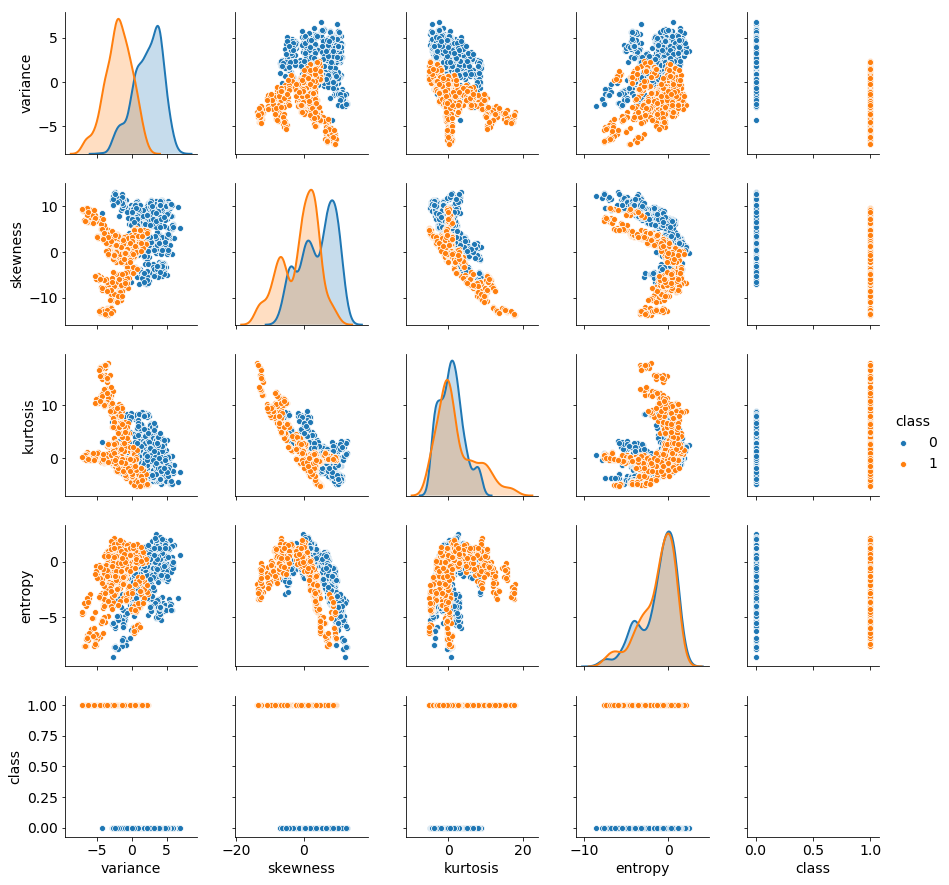

In [32]:
sns.pairplot(df, hue="class");

We can see from the plot that the two sets of banknotes seem quite well separable. In other words the orange and the blue scatters are not completely overlapped. This induces us to think that we will manage to build a good classifier and bust the counterfeiters.

Let's start by building a reference model using `Scikit-Learn`. As we have seen in [Lab 3](./03_Machine_Learning.ipynb), [`Scikit-Learn`](https://scikit-learn.org/stable/index.html) is a great Machine Learning library for Python. It implements many classical algorithms like **Decision Trees**, **Support Vector Machines**, **Random Forest** and more. It also has many preprocessing and model evaluation routines, so we strongly encourage you to learn to use it well.

For this Lab, we would like a model that trains fast, that does not require too much pre-processing and feature engineering, and that is known to give good results.

Luckily for us, such a model exists, and it's called **Random Forest**.

### Random Forest

[Random Forest](https://en.wikipedia.org/wiki/Random_forest) is an ensemble learning method for classification and regression that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. You can think of it as a Decision Tree on steroids!


Scikit Learn provides [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) ready to use in the `sklearn.ensemble` module.

For this Lab it is not fundamental that you understand the internals of how the Random Forest classifier works. The point here is that it is a model that works quite well and so we will use it for comparison.

Let's start by loading it:

In [33]:
from sklearn.ensemble import RandomForestClassifier

and let's create an instance of the model with default parameters:

In [34]:
model = RandomForestClassifier()

Now let's separate the features from labels as usual:

In [35]:
X = df.drop('class', axis=1).values
y = df['class'].values

and we are ready to train the model. In order to be quick and effective in judging the performance of our model we will use a 3-fold cross validation as done many times in [Lab 3](./03_Machine_Learning.ipynb#Cross-Validation). First we load the `cross_val_score` function:

In [36]:
from sklearn.model_selection import cross_val_score

And then we run it with the model, features and labels as arguments. This function will return 3 values for the test accuracy, one for each of the 3 folds.

In [37]:
cross_val_score(model, X, y)

array([0.99126638, 0.98905908, 0.99781182])

The Random Forest model seems to work really well on this dataset. We obtain an accuracy score higher than 99% with a 3-fold cross-validation. This is really good and it also shows us how in some cases traditional ML methods are very fast and effective solutions.

We can also get the score on a train/test split fixed set in order to compare it later with a Neural Network based model.

In [38]:
from sklearn.model_selection import train_test_split

Let's split up our data using the `train_test_split` function:

In [39]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3,
                     random_state=42)

Let's train our model and check the accuracy score now:

In [40]:
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9951456310679612

The accuracy on the test set is still very high.

### Logistic Regression Model

Let's build a Logistic Regression model in Keras and train it. As we have seen, the parameters of the model are updated using the gradient calculated from the cost function evaluated on the training data.

$$
\frac{d J(y, \hat{y}(w, X))}{d w}
$$


$X$ and $y$ here, indicate a pair of training features and labels.

In principle, we could feed the training data one point at a time. For each pair of features and label, calculate the cost and the gradient and update the weights accordingly. This procedure is called [**Stochastic Gradient Descent**](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) (also SGD). Once our model has seen each training data once, we say that an **Epoch** has completed, and we start again from the first training pair with the following epoch. Let's manually run one epoch on this simple model.

Then let's create a model as we have done in the previous labs.

Since this is a Logistic Regression, we will only have one Dense layer, with an output of 1 and a sigmoid activation function. By now you should be very familiar with all this, but in case you have doubts you may go back to [Lab 4](./04_Deep_Learning.ipynb) where we explained `Dense` layers in more detail.

Let's start with a few imports:

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

and then let's define the model. We will initialize the weights to one for this time, using the `kernel_initializer` parameter. It's not a good initialization, but it will guarantee that we all get the same results without any artifacts due to random initialization:

In [42]:
model = Sequential()
model.add(Dense(1, kernel_initializer='ones',
                input_shape=(4,), activation='sigmoid'))

Then we compile the model as usual. Notice that, since we only have one output node with a `sigmoid` activation, we will have to use the `binary_crossentropy` loss, also introduced in [Lab 4](./04_Deep_Learning.ipynb).

> TIP: As a reminder, binary crossentropy has the formula:
\begin{equation}
J(\hat{y}, y) =  - \; (y\log(\hat{y}) + (1 - y)\log(1 - \hat{y}))
\end{equation}
>
and it can be implemented in code as:
>
```python
def binary_crossentropy(y, y_hat):
    if y == 1:
        return - np.log(y_hat)
    else:
        return - np.log(1 - y_hat)
```

We compile the model using the `sgd` optimizer, which stands for **Stochastic Gradient Descent**. We will discuss this optimizer along with other more powerful ones [later in this lab](./05_Deep_Learning_Internals.ipynb#Optimizers), so stay tuned.

Finally, we will compile the model requesting to calculate the `accuracy` metric at each iteration.

In [43]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Finally, we save the random weights so that we can always reset the model to this starting point.

In [44]:
weights = model.get_weights()

The method `.train_on_batch` performs a single gradient update over one batch of samples, so we can use it to train the model on a single data point at a time and then visualize how the loss changes at each point.

We usually train models one batch at a time, passing several points at once and calculating the average gradient correction. The next plot will make it very clear why.

Let's train the model one point at a time first, for one epoch, i.e., passing all of the training data once:

In [45]:
losses = []
idx = range(len(X_train) - 1)
for i in idx:
    loss, _ = model.train_on_batch(X_train[i:i+1],
                                   y_train[i:i+1])
    losses.append(loss)

Let's plot the losses we have just calculated. As you will see the value of the loss changes greatly from one update to the next:

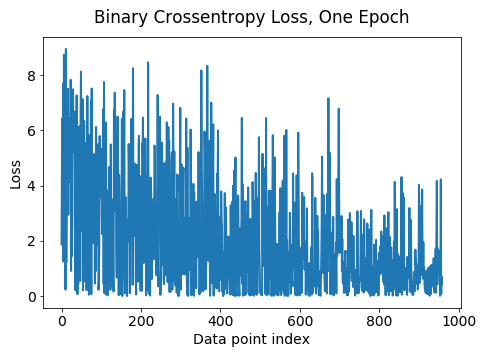

In [46]:
plt.plot(losses)
plt.title('Binary Crossentropy Loss, One Epoch')
plt.xlabel('Data point index')
plt.ylabel('Loss');

As you can see in the plot, passing one data point at a time results in a very **noisy** estimation of the gradient. We can improve the estimation of the gradient by averaging the gradients over a few points contained in a **mini-batch**.

Common choices for the mini-batch size are 16, 32, 64, 128, 256, and so on (generally powers of 2). With mini-batch gradient descent, we do $N/B$ weight updates per epoch, with $N$ equals to the number of points in the training set and $B$ equals to the number of points in a mini-batch.

Let's reset the model weights to their initial random values:

In [47]:
model.set_weights(weights)

Now let's train the model with batches of 16 points each:

In [48]:
B = 16

batch_idx = np.arange(0, len(X_train) - B, B)
batch_losses = []
for i in batch_idx:
    loss, _ = model.train_on_batch(X_train[i:i+B],
                                   y_train[i:i+B])
    batch_losses.append(loss)

Now let's plot the losses calculated with mini-batch gradient descent over the losses calculated at each point. As you will see, the loss decreases in a much smoother fashion:

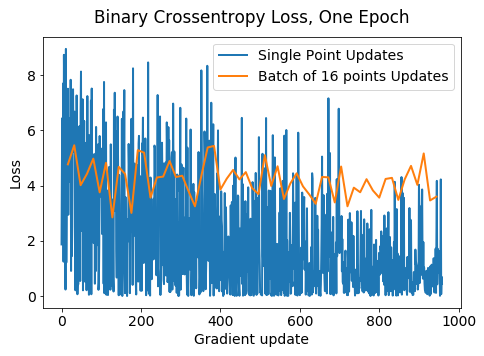

In [49]:
plt.plot(idx, losses)
plt.plot(batch_idx + B, batch_losses)
plt.title('Binary Crossentropy Loss, One Epoch')
plt.xlabel('Gradient update')
plt.ylabel('Loss')
plt.legend(['Single Point Updates',
            'Batch of 16 points Updates']);

The mini-batch method is what `tensorflow.keras` automatically does for us when we invoice the `.fit` method. When we run `model.fit` we can specify the number of `epochs` and the `batch_size`, like we have been doing many times:

In [50]:
model.set_weights(weights)

history = model.fit(X_train, y_train, batch_size=16,
                    epochs=20, verbose=0)

Now that we've trained the model, we can evaluate its performance on the test set using the `model.evaluate` method. This is somewhat equivalent to the `model.score` method in `Scikit-Learn`. It returns a dictionary with the loss, and all the other metrics we passed when we executed `model.compile`.

In [51]:
result = model.evaluate(X_test, y_test)
"Test accuracy: {:0.2f} %".format(result[1]*100)

412/412 [==============================] - 0s 182us/sample - loss: 0.6372 - accuracy: 0.7160


'Test accuracy: 71.60 %'

With 20 epochs of training the logistic regression model does not perform as well as the Random Forest model yet. Let's see how we can improve it. One direction that we can explore to improve a model is to tune the hyperparameters. We will start from the most obvious one, which is the **Learning Rate**.

### Learning Rates

Let's explore what happens to the performance of our model if we change the learning rate. We can do this with a simple loop where we perform the following steps:

1. We recompile the model with a different learning rate.
1. We reset the weights to the initial value.
1. We retrain the model and append the results to a list.

In [52]:
from tensorflow.keras.optimizers import SGD

In [53]:
dflist = []

learning_rates = [0.01, 0.05, 0.1, 0.5]

for lr in learning_rates:
    
    model.compile(loss='binary_crossentropy',
                  optimizer=SGD(lr=lr),
                  metrics=['accuracy'])

    model.set_weights(weights)
    h = model.fit(X_train, y_train, batch_size=16,
                  epochs=10, verbose=0)
    
    dflist.append(pd.DataFrame(h.history,
                               index=h.epoch))
    print("Done: {}".format(lr))

Done: 0.01
Done: 0.05
Done: 0.1
Done: 0.5


We can concatenate all our results in a single file for easy visualization using the `pd.concat` function along the columns axis.

In [54]:
historydf = pd.concat(dflist, axis=1)

In [55]:
historydf

,loss,accuracy,loss,accuracy,loss,accuracy,loss,accuracy
0,2.635399,0.254167,0.976025,0.678125,0.598464,0.798958,0.236048,0.920833
1,0.981185,0.563542,0.177659,0.941667,0.115639,0.968750,0.060799,0.977083
2,0.481212,0.797917,0.125036,0.966667,0.087417,0.977083,0.042496,0.988542
3,0.327098,0.889583,0.103359,0.972917,0.073017,0.980208,0.039550,0.985417
4,0.256914,0.910417,0.090870,0.972917,0.064694,0.985417,0.036811,0.986458
5,0.216372,0.931250,0.082347,0.975000,0.058890,0.984375,0.034518,0.985417
6,0.189870,0.938542,0.075493,0.977083,0.053717,0.986458,0.032246,0.984375
7,0.170938,0.945833,0.070571,0.981250,0.050083,0.985417,0.049037,0.983333
8,0.156796,0.948958,0.066229,0.982292,0.047571,0.986458,0.028265,0.988542
9,0.145766,0.955208,0.062599,0.982292,0.045660,0.987500,0.032222,0.987500


And we can add information about the learning rate in a secondary column index using the `pd.MultiIndex` class.

In [56]:
metrics_reported = dflist[0].columns
idx = pd.MultiIndex.from_product([learning_rates,
                                  metrics_reported],
                                 names=['learning_rate',
                                        'metric'])

historydf.columns = idx

In [57]:
historydf

learning_rate      0.01                0.05                0.10            \
metric             loss  accuracy      loss  accuracy      loss  accuracy   
0              2.635399  0.254167  0.976025  0.678125  0.598464  0.798958   
1              0.981185  0.563542  0.177659  0.941667  0.115639  0.968750   
2              0.481212  0.797917  0.125036  0.966667  0.087417  0.977083   
3              0.327098  0.889583  0.103359  0.972917  0.073017  0.980208   
4              0.256914  0.910417  0.090870  0.972917  0.064694  0.985417   
5              0.216372  0.931250  0.082347  0.975000  0.058890  0.984375   
6              0.189870  0.938542  0.075493  0.977083  0.053717  0.986458   
7              0.170938  0.945833  0.070571  0.981250  0.050083  0.985417   
8              0.156796  0.948958  0.066229  0.982292  0.047571  0.986458   
9              0.145766  0.955208  0.062599  0.982292  0.045660  0.987500   

learning_rate      0.50            
metric             loss  accuracy  
0              0.236048  0.920833  
1              0.060799  0.977083  
2              0.042496  0.988542  
3              0.039550  0.985417  
4              0.036811  0.986458  
5              0.034518  0.985417  
6              0.032246  0.984375  
7              0.049037  0.983333  
8              0.028265  0.988542  
9              0.032222  0.987500

Now we can display the behavior of loss and accuracy as a function of the learning rate.

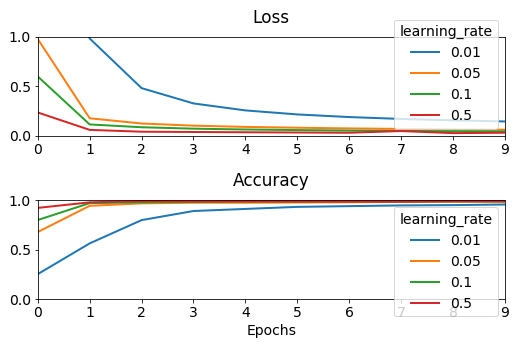

In [58]:
ax = plt.subplot(211)
hxs = historydf.xs('loss', axis=1, level='metric')
hxs.plot(ylim=(0,1), ax=ax)
plt.title("Loss")

ax = plt.subplot(212)
hxs = historydf.xs('accuracy', axis=1, level='metric')
hxs.plot(ylim=(0,1), ax=ax)
plt.title("Accuracy")
plt.xlabel("Epochs")

plt.tight_layout();

As expected a small learning rate gives a much slower decrease in the loss. Another hyperparameter we can try to tune is the **Batch Size**. Let's see how changing batch size affects the convergence of the model.

### Batch Sizes

Let's loop over increasing batch sizes from a single point up to `128`.

In [59]:
dflist = []

batch_sizes = [1, 8, 32, 128]

model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

for batch_size in batch_sizes:
    model.set_weights(weights)
    
    h = model.fit(X_train, y_train,
                  batch_size=batch_size,
                  verbose=0, epochs=20)
    
    dflist.append(pd.DataFrame(h.history,
                               index=h.epoch))
    print("Done: {}".format(batch_size))

Done: 1
Done: 8
Done: 32
Done: 128


Like we did above we can arrange the results in a `Pandas` Dataframe for easy display. Notice how we are using the `pd.MultiIndex.from_product` function to create a multi-index for the columns so that the data is organized by batch size and by metric.

In [60]:
historydf = pd.concat(dflist, axis=1)
metrics_reported = dflist[0].columns
idx = pd.MultiIndex.from_product([batch_sizes,
                                  metrics_reported],
                                 names=['batch_size',
                                        'metric'])
historydf.columns = idx

In [61]:
historydf

batch_size       1                   8                   32             \
metric          loss  accuracy      loss  accuracy      loss  accuracy   
0           2.083913  0.328125  3.913132  0.121875  4.329375  0.082292   
1           0.530544  0.779167  3.036032  0.196875  4.025856  0.114583   
2           0.290328  0.901042  2.452003  0.278125  3.757348  0.142708   
3           0.214352  0.930208  2.018445  0.319792  3.518683  0.156250   
4           0.176078  0.945833  1.660585  0.358333  3.304440  0.172917   
5           0.153547  0.951042  1.360697  0.423958  3.112358  0.189583   
..               ...       ...       ...       ...       ...       ...   
14          0.088749  0.975000  0.395841  0.840625  1.968609  0.321875   
15          0.085768  0.973958  0.368059  0.863542  1.875429  0.330208   
16          0.082959  0.978125  0.344611  0.881250  1.786038  0.342708   
17          0.080782  0.976042  0.324388  0.887500  1.700410  0.356250   
18          0.078526  0.977083  0.307165  0.892708  1.618341  0.367708   
19          0.076481  0.977083  0.291999  0.898958  1.539788  0.376042   

batch_size       128            
metric          loss  accuracy  
0           4.450403  0.077083  
1           4.361972  0.084375  
2           4.277488  0.089583  
3           4.195130  0.100000  
4           4.114891  0.107292  
5           4.037376  0.113542  
..               ...       ...  
14          3.439213  0.156250  
15          3.380934  0.163542  
16          3.324875  0.171875  
17          3.271181  0.171875  
18          3.218568  0.178125  
19          3.168123  0.184375  

[20 rows x 8 columns]

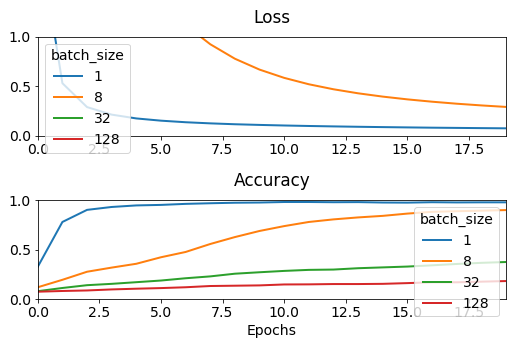

In [62]:
ax = plt.subplot(211)
hxs = historydf.xs('loss', axis=1, level='metric')
hxs.plot(ylim=(0,1), ax=ax)
plt.title("Loss")

ax = plt.subplot(212)
hxs = historydf.xs('accuracy', axis=1, level='metric')
hxs.plot(ylim=(0,1), ax=ax)
plt.title("Accuracy")
plt.xlabel("Epochs")

plt.tight_layout();

Smaller batches allow for more updates in a single epoch, on the other hand, they take much longer to run a single epoch, so there's a trade-off between speed of training (measured as number of gradients updates) and speed of convergence (measured as number of epochs). In practice a batch size of 16 or 32 data points is often used.

A [recent research article](https://arxiv.org/abs/1711.00489) suggests starting with a small batch size and the increase it gradually. We encourage you to try and experiment with that strategy as well.

## Optimizers

The **optimizer** is the algorithm used internally by Keras to update the weights and move the model towards lower values of the cost function. [Keras implements several optimizers](https://keras.io/optimizers/) that go by fancy names like SGD, Adam, RMSProp and many more. Despite these clever sounding names, the optimizers are all variations of the same concept, which is the [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) or SGD.


SGD is so fundamental that we have invented an acronym to help you remember it. If you find it hard to remember Stochastic Gradient Descent, think **S**imply **G**o **D**own, which is what SGD does!


>TIP: In the next pages you will find some mathematical symbols when we explain the algorithms. We highlighted the algorithms pseudo-code parts with a blue box like this: <div class="alert alert-block alert-info"> Here's the algorithm </div><br/>
> Feel free to skim through these if maths is not your favorite thing, you'll find a practical comparison of optimizers just after this section.

### Stochastic Gradient Descent (or Simply Go Down) and its variations

Let's begin our discovery of optimizers with a review of the SGD algorithm. SGD only needs one hyper-parameter: the learning rate. Once we know the learning rate, we proceed in a loop by:

1. Sampling a minibatch from the training set.
2. Computing the gradients.
3. Updating the weights by subtracting the gradient times the learning rate.


Using a bit more formal language, we can write SGD as:

#### SGD

<div class="alert alert-block alert-info">

- Choose an initial vector of parameters $w$ and learning rate $\eta$
- Repeat until stop rule:
    - Extract a random batch from the training set, with corresponding training labels
    - Evaluate the average cost function $J(y, \hat{y})$ using the points in the batch
    - Evaluate the gradient $g = \nabla_w J(w)$ using the points in the batch and the current value of the parameters $w$
    - Apply the update rule: $w -> w - \eta g$

</div>
<br/>

The stopping rule could be a fixed number of updates or epochs as well a condition on the amount of change in the cost function. For example, we could decide to stop the training loop if the value of the cost is not changing too much.

#### Momentum

In recent years, several improvements have been proposed to this formula.

A first improvement of the SGD is to add momentum. **Momentum** means that we accumulate the gradient corrections in a variable $v$ called _velocity_, that serves as a smoothed version of the gradient.

<div class="alert alert-block alert-info">

- Like SGD, choose an initial vector of parameters $w$, a learning rate $\eta$ and a momentum parameter $\mu$
- Repeat until stop rule:
    - Same 3 steps as SGD (get batch, evaluate cost, evaluate gradient)
    - Accumulate gradients into velocity: $v = \mu v - \eta g$
    - Apply the update rule: $w -> w - v$

</div>
<br/>

Applying momentum is like saying: if you are going down in a direction, then you should keep going more or less in that direction minus a small correction given by the new gradients. It's as if instead of walking downhill, we would roll down like a ball. The name comes from physics, in case you're curious.

#### AdaGrad

SGD and SGD + momentum keep the learning rate constant for each parameter. This method can be problematic if the parameters are sparse (i.e., most of them are zero except a few ones).

An adaptive algorithm, like **AdaGrad**, overcome this problem by accumulating the square of the gradient into a normalization variable for each of the parameters. The result of this is that each parameter will have a personalized learning rate. Parameters whose gradient is large will have a learning rate that decreases fast, while parameters that have small gradients will have a large learning rate.

This modification makes the loss converge faster than pure SGD.

<div class="alert alert-block alert-info">

- Like SGD, choose an initial vector of parameters $w$, a learning rate $\eta$, a small constant $\delta = 10^{-7}$ to avoid division by 0
- Repeat until stop rule:
    - Same 3 steps as SGD (get batch, evaluate cost, evaluate gradient)
    - Accumulate the square of the gradient: $r -> r + g \odot g$
    - Compute update: $\Delta w = \eta \frac{1}{\delta + \sqrt{r}} \odot g$
    - Apply the update rule $w -> w - \Delta w$

</div>
<br/>

Let's break down the above equation for the update so that we understand it fully. Both the accumulation step and the update step are computed element by element so that we can focus on a single parameter.

- For a single parameter $w_i$, $g \odot g$ is equivalent to $g_i^2$, so we are accumulating the square of the gradient in a variable $r_i$ for each parameter.

- $\frac{\eta}{\delta + \sqrt{r}} \odot g$ may look a bit daunting at first, so let's break it down. $\eta$ is the learning rate, no surprises here. For a single parameter $w_i$ we are dividing the value of the gradient $g_i$ by the square root of the accumulated square gradients $r_i$. If the gradients are large, we will be dividing by a large quantity. On the other hand, if the gradients are small, we will be dividing by a small quantity. This yields a practically constant update step size, multiplied by the learning rate. The $\delta$ in the denominator is a numerical regularization constant so that we do not risk dividing by zero if $r$ becomes too small.

#### RMSProp: Root Mean Square Propagation (or Adagrad with EWMA)

RMSProp is also adaptive, but it allows to choose the fraction of squared gradients to accumulate, using an [Exponentially Weighted Moving Average (or EWMA)](./Appendix.ipynb#EWMA) decay in the accumulation formula. If you're not familiar with how EWMA works, we strongly encourage you to review the [Appendix](./Appendix.ipynb#EWMA). EWMA is _the most important algorithm of your life_!

<div class="alert alert-block alert-info">

- Like SGD, choose an initial vector of parameters $w$, a learning rate $\eta$, a small constant $\delta = 10^{-7}$ to avoid division by zero and an EWMA mixing factor $\rho$ between 0 and 1, this is also called decay rate
- Repeat until stop rule:
    - Same 3 steps as SGD (get batch, evaluate cost, evaluate gradient)
    - Accumulate EWMA of the square of the gradient: $r -> \rho r + (1-\rho) g \odot g$
    - Same update rules as Adagrad

</div>
<br/>

#### Adam: Adaptive Moment Estimation (or EWMA everywhere)

Finally, let's introduce Adam. This algorithm improves upon RMSProp by applying EWMA to the gradient update as well as the square of the gradient.

<div class="alert alert-block alert-info">

- Like SGD, choose an initial vector of parameters $w$, a learning rate $\eta$, a small constant $\delta = 10^{-7}$ to avoid division by zero and an EWMA mixing factors $\rho_1$ and $\rho_2$ between 0 and 1 (usually chosen as 0.9 and 0.999 respectively)
- Repeat until stop rule:
    - Same 3 steps as SGD (get batch, evaluate cost, evaluate gradient)
    - Accumulate EWMA of the gradient: $v -> \rho_1 v + (1-\rho_2) g$
    - Accumulate EWMA the square of the gradient: $r -> \rho_2 r + (1-\rho_2) g \odot g$
    - Correct bias 1: $\hat{v} = \frac{v}{1 - \rho_1^t}$
    - Correct bias 2: $\hat{r} = \frac{r}{1 - \rho_2^t}$
    - Compute update: $\Delta w = \eta \frac{1}{\delta + \sqrt{\hat{r}}} \odot \hat{v}$
    - Apply the update rule $w -> w - \Delta w$

</div>
<br/>

This formula may also appear to be a bit complicated, so let's walk through it step by step.

- We apply EWMA to both the gradient and its square. We take inspiration from both the momentum and the RMSProp formulas.
- The only other novelty is the bias correction. We take the current value of the accumulated quantity and divide it by $(1 - \rho^t)$. Since both decay rates are almost 1, the normalization is very small initially, and it increases as time goes by. This seems to work in practice well.

In summary, we have seen a few of the most popular optimization algorithms. You are probably wondering how to choose the best one. Unfortunately, there is no best one, and each of them performs better in some conditions. What is true though, is that a good choice of the hyperparameters is key for an algorithm to perform well, and we encourage you to familiarize yourself with one algorithm and understand the effects of changing hyperparameter.

Let's compare the performance of a few optimizers in Keras. Optimizers are available in the `keras.optimizer` module, so let's start by importing them:

In [63]:
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, RMSprop

We then set the learning rate to be the same for each of them and run the training for five epochs each:

In [64]:
dflist = []

opts = ['SGD(lr=0.01)',
        'SGD(lr=0.01, momentum=0.3)',
        'SGD(lr=0.01, momentum=0.3, nesterov=True)',  
        'Adam(lr=0.01)',
        'Adagrad(lr=0.01)',
        'RMSprop(lr=0.01)']

for opt_name in opts:
    model.compile(loss='binary_crossentropy',
                  optimizer=eval(opt_name),
                  metrics=['accuracy'])
    
    model.set_weights(weights)
    
    h = model.fit(X_train, y_train, batch_size=16,
                  epochs=5, verbose=0)
    
    dflist.append(pd.DataFrame(h.history,
                               index=h.epoch))
    print("Done: ", opt_name)

Done:  SGD(lr=0.01)
Done:  SGD(lr=0.01, momentum=0.3)
Done:  SGD(lr=0.01, momentum=0.3, nesterov=True)
Done:  Adam(lr=0.01)
Done:  Adagrad(lr=0.01)
Done:  RMSprop(lr=0.01)


We can aggregate the results as we did previously:

In [65]:
historydf = pd.concat(dflist, axis=1)
metrics_ = dflist[0].columns
idx = pd.MultiIndex.from_product([opts, metrics_],
                                 names=['optimizers',
                                        'metric'])
historydf.columns = idx

and plot them for comparison:

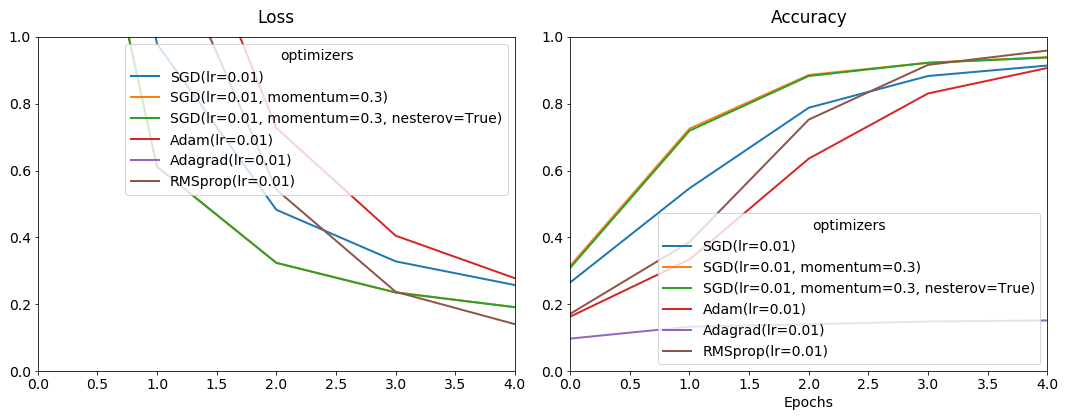

In [66]:
plt.figure(figsize=(15, 6))

ax = plt.subplot(121)
hxs = historydf.xs('loss', axis=1, level='metric')
hxs.plot(ylim=(0,1), ax=ax)
plt.title("Loss")

ax = plt.subplot(122)
hxs = historydf.xs('accuracy', axis=1, level='metric')
hxs.plot(ylim=(0,1), ax=ax)
plt.title("Accuracy")
plt.xlabel("Epochs")

plt.tight_layout();

As you can see, in this particular case, some optimizers converge a lot faster than others. This could be due to the particular combination of hyper-parameters chosen as well as to their better performance on this particular problem. We encourage you to try out different optimizers on your problems, as well as trying different hyper-parameter combinations.

## Initialization

So far we have explored the effect of learning rate, batch size, and optimizers on the speed of convergence of a model. We have compared their effect starting from the same set of randomly initialized weights. What if we initialized weights in a different weight and kept everything else fixed? This may seem unimportant, but it turns out that the initialization is critical. A model could not converge at all for some initialization and converge quickly for some other initialization. While we don't understand this fully, we have a few heuristic strategies available, that we can test, looking for the best one for our specific problem.

`keras` offers the possibility to initialize the weights in several ways including:

- Zeros, ones, constant: all weights initialized to zero, to one or a fixed value. Generally, these are not good choices, because they leave the model uncertain on which parameters to optimize first.

Initialization strategies try to "break the symmetry" by assigning random values to the parameters. The range and type of random distribution can vary, and several initialization schemes have are available:

- *Random uniform*: each weight receives a random value between 0 and 1, chosen with uniform probability.
- *Lecun_uniform*: like the above, but the values are drawn in the interval [-limit, limit] where limit is $\frac{\sqrt{3}}{\textrm{\# inputs}}$. Where $\textrm{\# inputs}$ indicates the number of inputs in the weight tensor for a specific layer.
- *Normal*: each weight receives a random value drawn from a normal distribution with mean 0 and standard deviation of 1.
- *He_normal*: like the previous one, but with standard deviation $\sigma = \sqrt{\frac{2}{\textrm{\# in}}}$.
- *Glorot_normal*: like the previous one, but with standard deviation  $\sigma = \sqrt{\frac{2}{\textrm{\# in} + \textrm{\# out}}}$.

You can read more about them [here](https://keras.io/initializers/). To see the effect of initialization, we'll use a deeper network with more than just five weights.

In [67]:
import tensorflow.keras.backend as K

In [68]:
dflist = []

inits = ['zeros', 'ones', 'uniform', 'lecun_uniform',
         'normal', 'he_normal', 'glorot_normal']

for init in inits:

    K.clear_session()

    model = Sequential()
    model.add(Dense(10, input_shape=(4,),
                    kernel_initializer=init,
                    activation='tanh'))
    model.add(Dense(10, kernel_initializer=init,
                    activation='tanh'))
    model.add(Dense(10, kernel_initializer=init,
                    activation='tanh'))
    model.add(Dense(1, kernel_initializer=init,
                    activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])

    h = model.fit(X_train, y_train, batch_size=16,
                  epochs=10, verbose=0)
    
    dflist.append(pd.DataFrame(h.history,
                               index=h.epoch))
    print("Done: ", init)

Done:  zeros
Done:  ones
Done:  uniform
Done:  lecun_uniform
Done:  normal
Done:  he_normal
Done:  glorot_normal


Let's aggregate and plot the results

In [69]:
historydf = pd.concat(dflist, axis=1)
metrics_ = dflist[0].columns
idx = pd.MultiIndex.from_product([inits, metrics_],
                                 names=['initializers',
                                        'metric'])

historydf.columns = idx

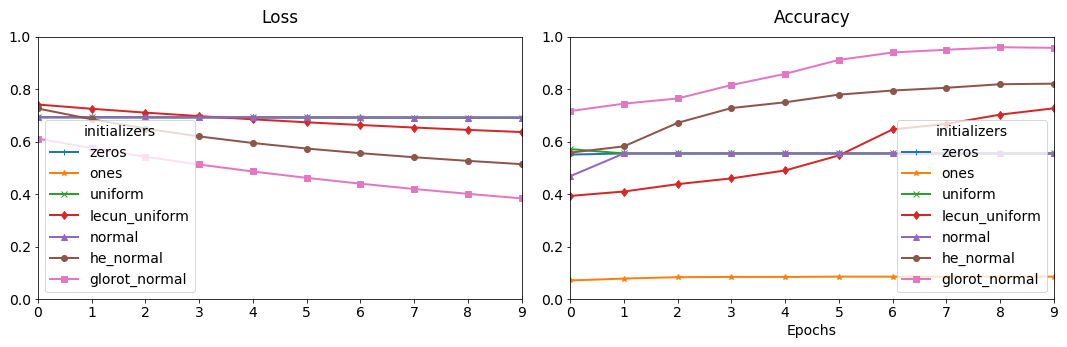

In [70]:
styles = ['-+', '-*', '-x', '-d', '-^', '-o', '-s'] 

plt.figure(figsize=(15, 5))

ax = plt.subplot(121)
xs = historydf.xs('loss', axis=1, level='metric')
xs.plot(ylim=(0,1), ax=ax, style=styles)
plt.title("Loss")

ax = plt.subplot(122)
xs = historydf.xs('accuracy', axis=1, level='metric')
xs.plot(ylim=(0,1), ax=ax, style=styles)
plt.title("Accuracy")
plt.xlabel("Epochs")

plt.tight_layout();

As you can see some initializations don't even converge, while some do converge rather quickly. Initialization of the weights plays a significant role in large models, so it is important to try a couple of different initialization schemes to get the best results.

## Inner layer representation

We conclude this dense lab on how to train a Neural Network with a little treat. As mentioned previously, a Neural Network can be viewed as a general function between any input and any output. This is also true for any of the intermediate layers. Each layer learns a nonlinear transformation between its inputs and its outputs so that we can pull out the values at the output of any layer. This gives us a way to see how our network is learning to separate our data. Let's see how it happens. First of all, we will re-train a network with two layers, the first with two nodes and the second with just one output node.

Let's clear the backend session first:

In [71]:
K.clear_session()

Then we define and compile the model:

In [72]:
model = Sequential()
model.add(Dense(2, input_shape=(4,), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.01),
              metrics=['accuracy'])

We then set the odel weights to some random values. In order to get reproducible results, the random values are given for this particular run:

In [73]:
weights = [np.array([[-0.26285839,  0.82659411],
                     [ 0.65099144, -0.7858932 ],
                     [ 0.40144777, -0.92449236],
                     [ 0.87284446, -0.59128475]]),
           np.array([ 0.,  0.]),
           np.array([[-0.7150408 ], [ 0.54277754]]),
           np.array([ 0.])]

model.set_weights(weights)

And then we train the model

In [74]:
h = model.fit(X_train, y_train,
              batch_size=16, epochs=20,
              verbose=0, validation_split=0.3)

Let's look at the layers using the `model.summary` function:

In [75]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 10        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


The model only has 2 dense layers. One connecting the input to the 2 inner nodes and one connecting these 2 inner nodes to the output. The list of layers is accessible as an attribute of the model:

In [76]:
model.layers

and the inputs and outputs of each layer are also accessible as attributes. Let's take the input of the first layer and the output of the first layer, the one with 2 nodes:

In [77]:
inp = model.layers[0].input
out = model.layers[0].output

These variables refer to objects from the keras kernel. This is Tensorflow by default but it can be switched to other kernels if needed.

In [78]:
inp

<tf.Tensor 'dense_input_8:0' shape=(None, 4) dtype=float32>

In [79]:
out

<tf.Tensor 'dense_10/Relu:0' shape=(None, 2) dtype=float32>

Both the input and the output are Tensorflow tensors. In the next lab we will learn more about Tensors, so don't worry about them for now.

`keras` allows us to define a function between any tensors in a model as follows:

In [80]:
features_function = K.function([inp], [out])

Notice that `features_function` is a function itself, so `K.function` is a function that returns a function.

In [81]:
features_function

We can apply this function to the test data. Notice that the function expects a list of inputs and returns a list of outputs. Since our inputs list only has one element, so will the output list and we can extract the outputs by taking the first element:

In [82]:
features = features_function([X_test])[0]

The output tensor contains as many points as `X_test` each represented by 2 numbers, the output values of the 2 nodes in the first layer:

In [83]:
features.shape

(412, 2)

We can plot the data as a scatter plot, and we can see how the network has learned to represent the data in 2 dimensions in such a way that the next layer can separate the 2 classes more easily:

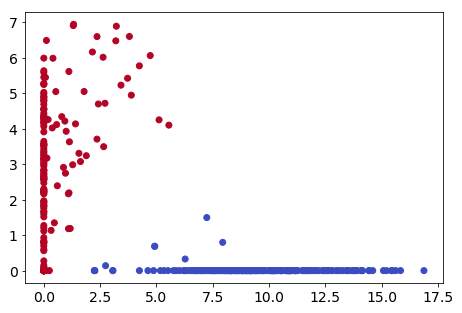

In [84]:
plt.scatter(features[:, 0], features[:, 1], c=y_test, cmap='coolwarm');

Let's plot the output of the second-to-last layer at each epoch in a training loop. First we re-initialize the model:

In [85]:
model.set_weights(weights)

Then we create a `K.function` between the input and the output of layer 0:

In [86]:
inp = model.layers[0].input
out = model.layers[0].output
features_function = K.function([inp], [out])

Then we train the model one epoch at a time, plotting the 2D representation of the data as it comes out from layer 0:

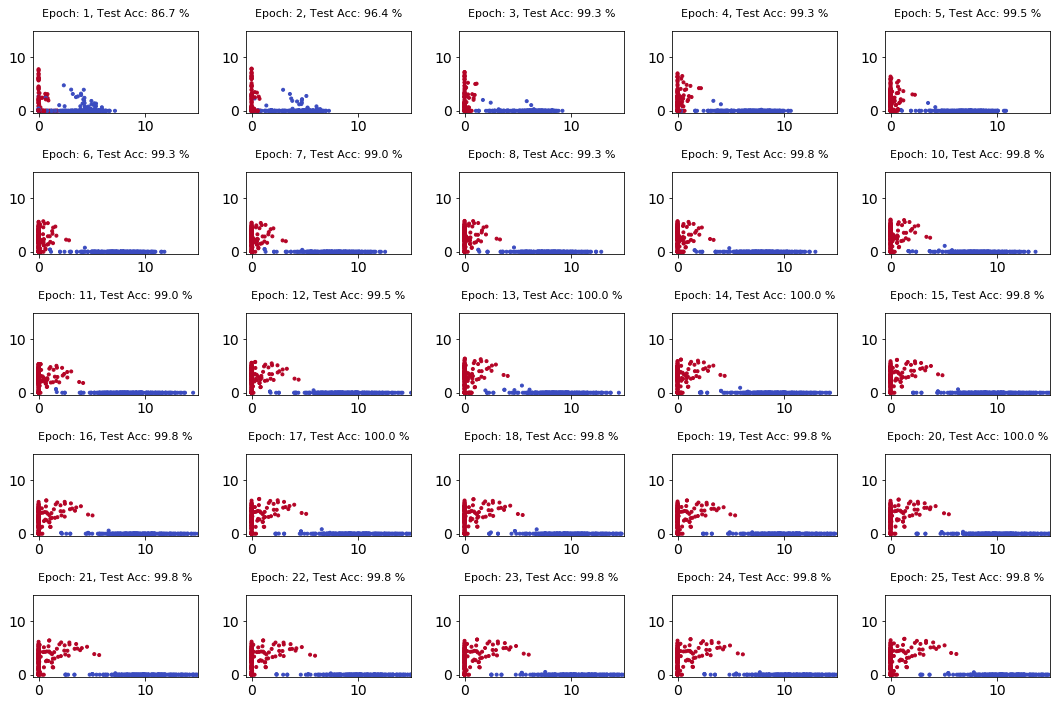

In [87]:
plt.figure(figsize=(15,10))

for i in range(1, 26):
    plt.subplot(5, 5, i)
    h = model.fit(X_train, y_train, batch_size=16,
                  epochs=1, verbose=0)
    test_acc = model.evaluate(X_test, y_test,
                              verbose=0)[1]
    features = features_function([X_test])[0]
    plt.scatter(features[:, 0], features[:, 1],
                c=y_test, cmap='coolwarm', marker='.')
    plt.xlim(-0.5, 15)
    plt.ylim(-0.5, 15)
    
    acc_ = test_acc * 100.0
    t = 'Epoch: {}, Test Acc: {:3.1f} %'.format(i, acc_)
    plt.title(t, fontsize=11)

plt.tight_layout();

As you can see, at the beginning the network has no notion of the difference between the two classes. As the training progresses, the network learns to represent the data in a 2 dimensional space where the 2 classes are linearly separable, so that the final layer (which is basically a logistic regression) can easily separate them with a straight line.

This lab was surely more intense and theoretical than the previous ones, but we hope it gave you a thorough understanding of the inner workings of how a Neural Network works and what you can do to improve its performance.

## Exercises

### Exercise 1

You've just started to work at a wine company, and they would like you to help them build a model that predicts the quality of their wine based on several measurements. They give you a dataset with wine:

- load the ../data/wines.csv into Pandas
- use the column called "Class" as the target
- check how many classes are there in the target, and if necessary use dummy columns for a Multiclass classification
- use all the other columns as features, check their range and distribution (using seaborn pairplot)
- rescale all the features using either MinMaxScaler or StandardScaler
- build a deep model with at least one hidden layer to classify the data
- choose the cost function, what will you use? Mean Squared Error? Binary Cross-Entropy? Categorical Cross-Entropy?
- choose an optimizer
- choose a value for the learning rate. You may want to try with several values
- choose a batch size
- train your model on all the data using a `validation_split=0.2`. Can you converge to 100% validation accuracy?
- what's the minimum number of epochs to converge?
- repeat the training several times to verify how stable your results are

### Exercise 2

Since this dataset has 13 features, we can only visualize pairs of features as we did in the pairplot. We could, however, exploit the fact that a Neural Network is a function to extract two high-level features to represent our data.

- build a deep fully connected network with the following structure:
    - Layer 1: 8 nodes
    - Layer 2: 5 nodes
    - Layer 3: 2 nodes
    - Output: 3 nodes
- choose activation functions, initializations, optimizer, and learning rate so that it converges to 100% accuracy within 20 epochs (not easy)
- remember to train the model on the scaled data
- define a Feature Function as we did above between the input of the 1st layer and the output of the 3rd layer
- calculate the features and plot them on a 2-dimensional scatter plot
- can we distinguish the three classes well?

### Exercise 3

Keras functional API. So far we've always used the Sequential model API in Keras. However, Keras also offers a Functional API, which is much more powerful. You can find its [documentation here](https://keras.io/getting-started/functional-api-guide/). Let's see how we can leverage it.

- define an input layer called `inputs`
- define two hidden layers as before, one with eight nodes, one with five nodes
- define a `second_to_last` layer with 2 nodes
- define an output layer with three nodes
- create a model that connects input and output
- train it and make sure that it converges
- define a function between inputs and second_to_last layer
- recalculate the features and plot them

### Exercise 4

Keras offers the possibility to call a function at each epoch. These are Callbacks, and their [documentation is here](https://keras.io/callbacks/). Callbacks allow us to add some neat functionality. In this exercise, we'll explore a few of them.

- Split the data into train and test sets with a test_size = 0.3 and random_state=42
- Reset and recompile your model
- train the model on the train data using `validation_data=(X_test, y_test)`
- Use the `EarlyStopping` callback to stop your training if the `val_loss` doesn't improve
- Use the `ModelCheckpoint` callback to save the trained model to disk once training is over
- Use the `TensorBoard` callback to output your training information to a `/tmp/` subdirectory

You can use tensorboard in the notebook by running the following two commands:

```python
%load_ext tensorboard.notebook

%tensorboard --logdir /tmp/ztdlbook/tensorboard/
```

You can also run tensorboard in a separate terminal with the command:

```bash
tensorboard --logdir /tmp/ztdl/tensorboard/
```
and then open another browser window at address: http://localhost:6006.